In [21]:
# !pip install openai

In [1]:
from IPython.display import display, Image, Audio

import cv2 
import base64
import time
from openai import OpenAI
import os
import requests

import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import io
from PIL import Image
from IPython.display import display

from collections import OrderedDict
import pandas as pd

from sklearn.model_selection import train_test_split

from pkg_resources import packaging

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\AlexTerentowicz\AppData\Local\Temp\ipykernel_1424\1376338716.py:26: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


In [2]:
from openai import OpenAI

# make sure to replace the api_key with your own
client = OpenAI(
    api_key="key"
)

Example interaction:

In [2]:


completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": "Write a haiku about recursion in programming."
        }
    ]
)

print(completion.choices[0].message)

ChatCompletionMessage(content='Functions call themselves,  \nLayers deep in logic flow,  \nInfinite resolve.', refusal=None, role='assistant', function_call=None, tool_calls=None)


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import json

frame_types = ["frame_first", "frame_half", "frame_last", "comic_3", "comic_4"]

def vid_path(filename):
    return f'.\\data\\video\\train_all\\{filename}'

def load_video(filename):
    cap = cv2.VideoCapture(filename)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return np.array(frames)

def load_utt(vid_no, utt_no, text_data):
    utt = text_data[vid_no]['conversation'][utt_no-1]
    vid = load_video(vid_path(utt['video_name']))
    return vid, utt

def load_frame(fname, frame_type):
    path = f'./data/preproc/{frame_type}/{fname}.jpg'
    frame = cv2.imread(path)
    return frame

def frame_to_img(frame):
    # frame = Image.fromarray(frame).convert("RGB")
    # frame = Image.fromarray(np.array(frame)[:, :, ::-1])
    
    frame = Image.fromarray(frame[:, :, ::-1])
    return  frame

with open('data/Subtask_2_train.json') as f:
    text_data_list = json.load(f)
    # text data is a map of conversation id to conversation
    text_data = {text['conversation_ID']: text for text in text_data_list}

e:\repos_kioxia\win\mgr\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\repos_kioxia\win\mgr\.venv\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [131]:
def construct_clsf_prompt(utt):
    clsf_prompt = "These are frames from a movie scene. The dialogue is: '"
    clsf_prompt +=  utt + "' "
    clsf_prompt += "Classify the emotion of the character in this scene. The options are: "
    clsf_prompt += "'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'"
    clsf_prompt += "Provide only one label."
    clsf_prompt += "The response format is: {\"emotion\": \"<selected class>\"}"

    # # no text version - to check if the model can infer the emotion from the frames themselves
    # clsf_prompt = "These are frames from a movie scene."
    # clsf_prompt += "Classify the emotion of the character in this scene. The options are: "
    # clsf_prompt += "'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'"
    # clsf_prompt += "Provide only one label."
    # clsf_prompt += "The response format is: {\"emotion\": \"<selected class>\"}"

    return clsf_prompt

.\data\video\train_all\dia955utt6.mp4
62 frames read.
All right .
neutral


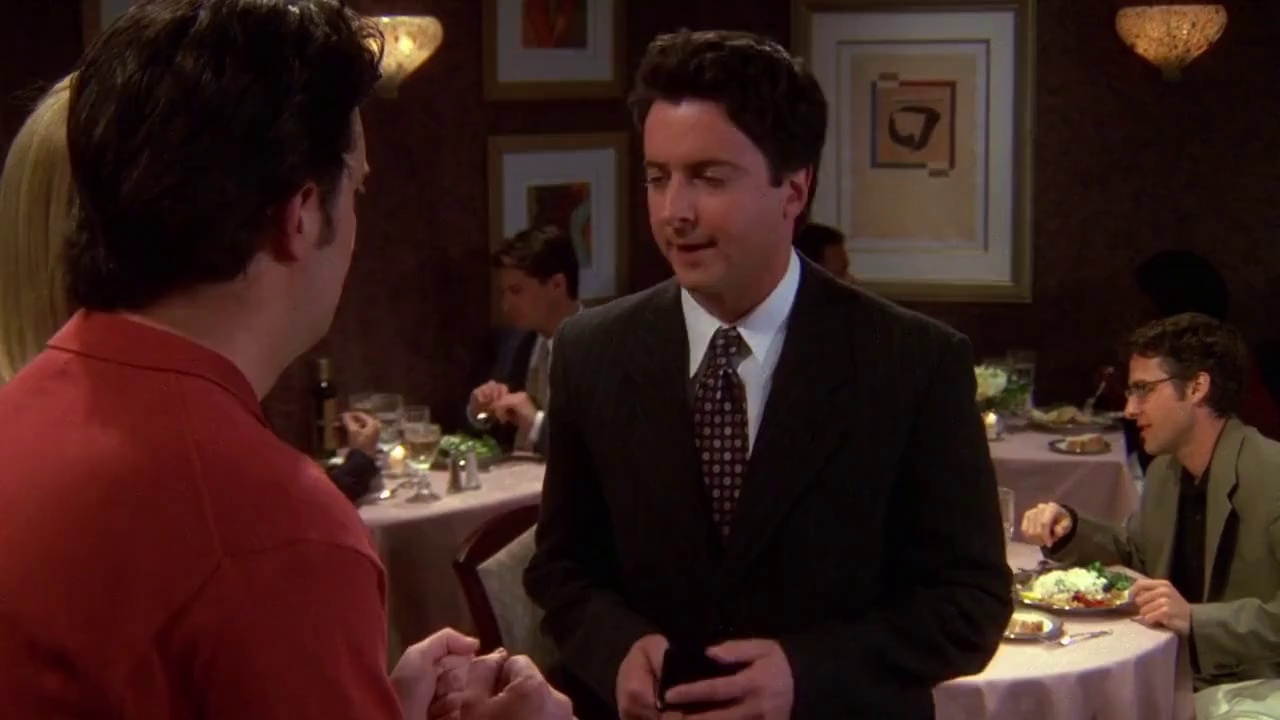

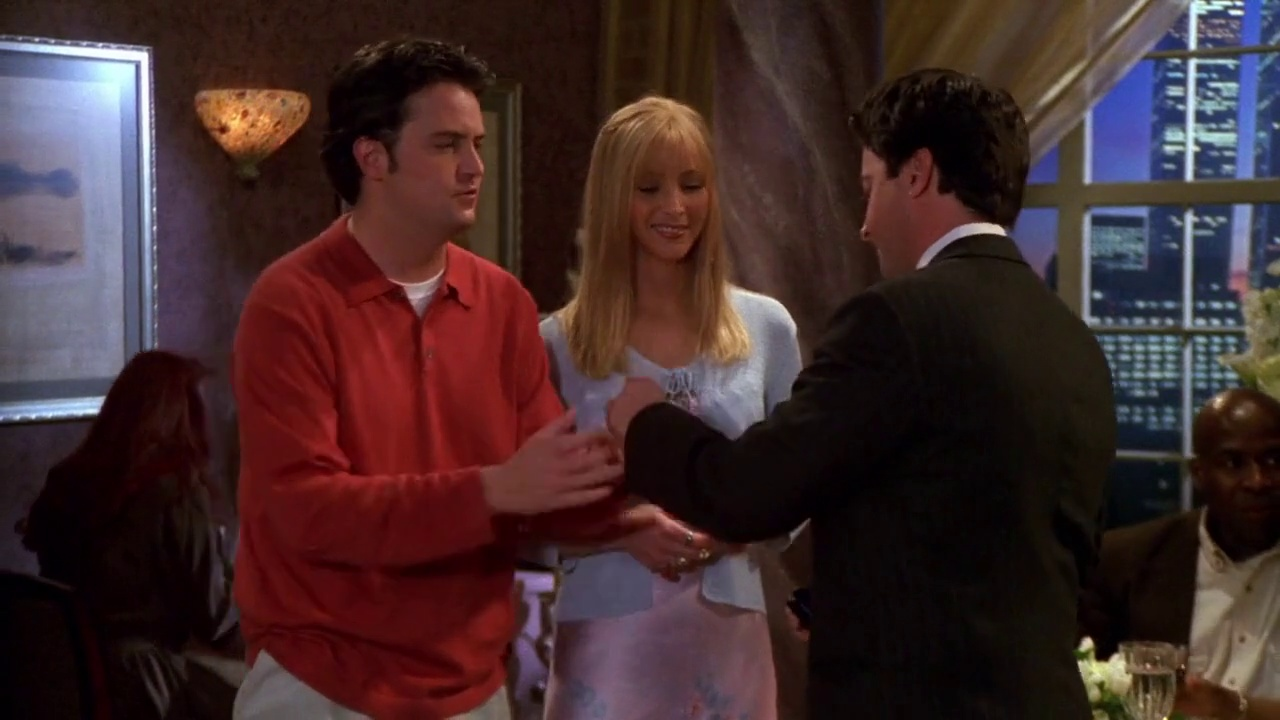

In [129]:
# conv_id, utt_id = 215, 4
# conv_id, utt_id = 8, 1
# conv_id, utt_id = 856, 11

# conv_id, utt_id = 1237, 5 # parsing error
# conv_id, utt_id = 49, 8 # parsing error
conv_id, utt_id = 955, 6 # parsing error


fname = text_data[conv_id]['conversation'][utt_id-1]['video_name']
fpath = vid_path(fname)
print(fpath)

video = cv2.VideoCapture(fpath)

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()

print(len(base64Frames), "frames read.")
print(text_data[conv_id]['conversation'][utt_id-1]['text'])
print(text_data[conv_id]['conversation'][utt_id-1]['emotion'])

for frame in base64Frames[0::50]:
    image = Image.open(io.BytesIO(base64.b64decode(frame)))
    display(image)
    
    # print image shape
    # print(np.array(image).shape)

In [132]:
utt = text_data[conv_id]['conversation'][utt_id-1]['video_name']
frame_fps_interval = 50
resize_dim = 512

PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            construct_clsf_prompt(utt),
            *map(lambda x: {"image": x, "resize": resize_dim}, base64Frames[0::frame_fps_interval]),
        ],
    },
]
params = {
    "model": "gpt-4o-2024-08-06",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 20,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)


{"emotion": "neutral"}


In [71]:
print(params)

{'model': 'gpt-4o-2024-08-06', 'messages': [{'role': 'user', 'content': ['These are frames from a movie scene. The dialogue is: \'dia215utt4.mp4\' Classify the emotion of the character in this scene. The options are: \'anger\', \'disgust\', \'fear\', \'joy\', \'neutral\', \'sadness\', \'surprise\'Provide only one label.The response format is: {"emotion": "<selected class>"}', {'image': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCALQBQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBh

In [27]:
import json

# parese the response in a json format
response = result.choices[0].message.content
predicted_emotion = json.loads(response)['emotion']
print(predicted_emotion)

anger


# Prepare data

In [10]:
with open('data/Subtask_2_train.json') as f:
    text_data_list = json.load(f)
    # text data is a map of conversation id to conversation
    text_data = {text['conversation_ID']: text for text in text_data_list}

# list of video filenames
texts = []
video_fnames_list = []
n_utts = 0
labels = []

for c_id, conv in text_data.items():
    n_utts += len(conv['conversation'])
    for utt in conv['conversation']:
        # u_id = utt['utterance_ID']
        texts.append(utt['text'])
        labels.append(utt['emotion'])
        video_fnames_list.append(utt['video_name'])

print(len(video_fnames_list), n_utts)

13619 13619


In [11]:
print(texts[:3])
print(labels[:3])

['Alright , so I am back in high school , I am standing in the middle of the cafeteria , and I realize I am totally naked .', 'Oh , yeah . Had that dream .', 'Then I look down , and I realize there is a phone ... there .']
['neutral', 'neutral', 'surprise']


Split the dataset

In [12]:
train_indices, test_indices = train_test_split(range(len(video_fnames_list)), test_size=0.2, random_state=42)

# lengths
print(len(train_indices), len(test_indices))

# create a list of video filenames, X_train, X_test, Y_train, Y_test

train_video_fnames = [video_fnames_list[i] for i in train_indices]
test_video_fnames = [video_fnames_list[i] for i in test_indices]

# split texts and labels by indices
train_texts = [texts[i] for i in train_indices]
test_texts = [texts[i] for i in test_indices]

train_labels = [labels[i] for i in train_indices]
test_labels = [labels[i] for i in test_indices]

10895 2724


# Classify
### Perform classification using GPT-4o in batches

In [6]:
batch_size = 50

test_batches_indices = [
    list(range(i, min(i + batch_size, len(test_video_fnames))))
    for i in range(0, len(test_video_fnames), batch_size)
    ]

batch_nos = list(range(len(test_batches_indices)))
batch_ids = [f"b_{str(i)}_step_{batch_size}"  for i in batch_nos]
# print(batch_ids)

# zip the batch ids with the test batches
test_batches = list(zip(batch_ids, test_batches_indices))
print(test_batches[0])
print(test_batches[-1])

('b_0_step_50', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
('b_54_step_50', [2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723])


In [139]:
frame_fps_interval = 50
resize_dim = 512

# test_batches_batch = test_batches
# test_batches_batch = test_batches[:2]
# test_batches_batch = test_batches[2:10]
# test_batches_batch = test_batches[10:12]
### up until batch 12, by mistake, the dict was not zeroed out on every batch and the results appended instead.
### the results of all batches from 0 to 11 are stored 3 jsons in "/results/gpt-4o/complete_runs"
### after that, its 1 file per batch

# test_batches_batch = test_batches[12:20]
# test_batches_batch = test_batches[20:30]
test_batches_batch = test_batches[30:]
 

start = time.time()
for batch_id, batch_indices in test_batches_batch:

    predicted_labels = {}
    for i in batch_indices:
        if i % 5 == 0:
            print(f"[{round(time.time()-start, 2)}s] test set completion: {i}/{len(test_video_fnames)}")

        fname = test_video_fnames[i]
        fpath = vid_path(fname)
        video = cv2.VideoCapture(fpath)
        # print(fpath)

        base64Frames = []
        while video.isOpened():
            success, frame = video.read()
            if not success:
                break
            _, buffer = cv2.imencode(".jpg", frame)
            base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

        video.release()

        reduced_base64Frames = base64Frames[0::frame_fps_interval]

        utt = text_data[conv_id]['conversation'][utt_id-1]['video_name']        
        PROMPT_MESSAGES = [
            {
                "role": "user",
                "content": [
                    construct_clsf_prompt(utt),
                    *map(lambda x: {"image": x, "resize": resize_dim}, reduced_base64Frames),
                ],
            },
        ]
        params = {
            "model": "gpt-4o-2024-08-06",
            "messages": PROMPT_MESSAGES,
            "max_tokens": 20,
        }

        result = client.chat.completions.create(**params)

        response = result.choices[0].message.content
        predicted_labels[fname] = {"response": response, "frame_length": len(reduced_base64Frames)}
        try:
            predicted_emotion = json.loads(response)['emotion']
            predicted_labels[fname]['predicted_emotion'] = predicted_emotion
        except:
            predicted_labels[fname]['predicted_emotion'] = "parsing error"

    with open(f'experiments/results/gpt-4o/predicted_labels_{batch_id}.json', 'w') as f:
        json.dump(predicted_labels, f)

# count frame lengths where it was 0
        

[0.0s] test set completion: 1500/2724
[32.7s] test set completion: 1505/2724
[55.35s] test set completion: 1510/2724
[101.73s] test set completion: 1515/2724
[120.24s] test set completion: 1520/2724
[144.93s] test set completion: 1525/2724
[175.32s] test set completion: 1530/2724
[212.0s] test set completion: 1535/2724
[247.26s] test set completion: 1540/2724
[274.09s] test set completion: 1545/2724
[302.58s] test set completion: 1550/2724
[326.62s] test set completion: 1555/2724
[353.39s] test set completion: 1560/2724
[380.87s] test set completion: 1565/2724
[421.92s] test set completion: 1570/2724
[449.79s] test set completion: 1575/2724
[477.78s] test set completion: 1580/2724
[502.53s] test set completion: 1585/2724
[528.13s] test set completion: 1590/2724
[549.81s] test set completion: 1595/2724
[576.19s] test set completion: 1600/2724
[605.97s] test set completion: 1605/2724
[624.8s] test set completion: 1610/2724
[651.99s] test set completion: 1615/2724
[675.0s] test set comple

: 

In [ ]:
conv_id, utt_id = 215, 4
fname = text_data[conv_id]['conversation'][utt_id-1]['video_name']
fpath = vid_path(fname)

video = cv2.VideoCapture(fpath)

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

### Load the final results

In [4]:
# read results from all jsons under results/gpt-4o/
# and add them all to a single dict

predicted_labels = {}

# iterate over all files found in the directory
for filename in os.listdir('experiments/results/gpt-4o/'):
    if filename.endswith(".json"):
        with open(f'experiments/results/gpt-4o/{filename}', 'r') as f:
            data = json.load(f)
            predicted_labels.update(data)

print(len(predicted_labels))

2724


In [5]:
# transform the dict into a list of labels
predicted_labels_dict = {}
for k, v in predicted_labels.items():
    predicted_labels_dict[k] = v['predicted_emotion']

# get value counts of all labels
predicted_labels_df = pd.Series(predicted_labels_dict)
predicted_labels_df.value_counts()

neutral          809
joy              557
parsing error    353
surprise         303
disgust          280
sadness          199
anger            190
confusion         12
fear              12
frustration        7
nervousness        1
worry              1
Name: count, dtype: int64

In [6]:
# translate all abnormal labels in predicted_labels_dict to "neutral"
for k, v in predicted_labels_dict.items():
    if v not in ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']:
        predicted_labels_dict[k] = 'neutral'

# get value counts of all labels
predicted_labels_df = pd.Series(predicted_labels_dict)
predicted_labels_df.value_counts()

neutral     1183
joy          557
surprise     303
disgust      280
sadness      199
anger        190
fear          12
Name: count, dtype: int64

In [13]:
# create a list ordered by the video filenames
predicted_labels_list = [predicted_labels_dict[k] for k in test_video_fnames]

In [14]:
print([predicted_labels_dict[k] for k in test_video_fnames[:10]])

['neutral', 'disgust', 'anger', 'surprise', 'joy', 'neutral', 'disgust', 'neutral', 'neutral', 'surprise']


In [15]:
test_video_fnames[:10]

['dia856utt11.mp4',
 'dia540utt7.mp4',
 'dia1170utt7.mp4',
 'dia856utt16.mp4',
 'dia476utt3.mp4',
 'dia342utt9.mp4',
 'dia891utt12.mp4',
 'dia1316utt9.mp4',
 'dia1290utt3.mp4',
 'dia562utt1.mp4']

In [16]:
predicted_labels_list[:10]

['neutral',
 'disgust',
 'anger',
 'surprise',
 'joy',
 'neutral',
 'disgust',
 'neutral',
 'neutral',
 'surprise']

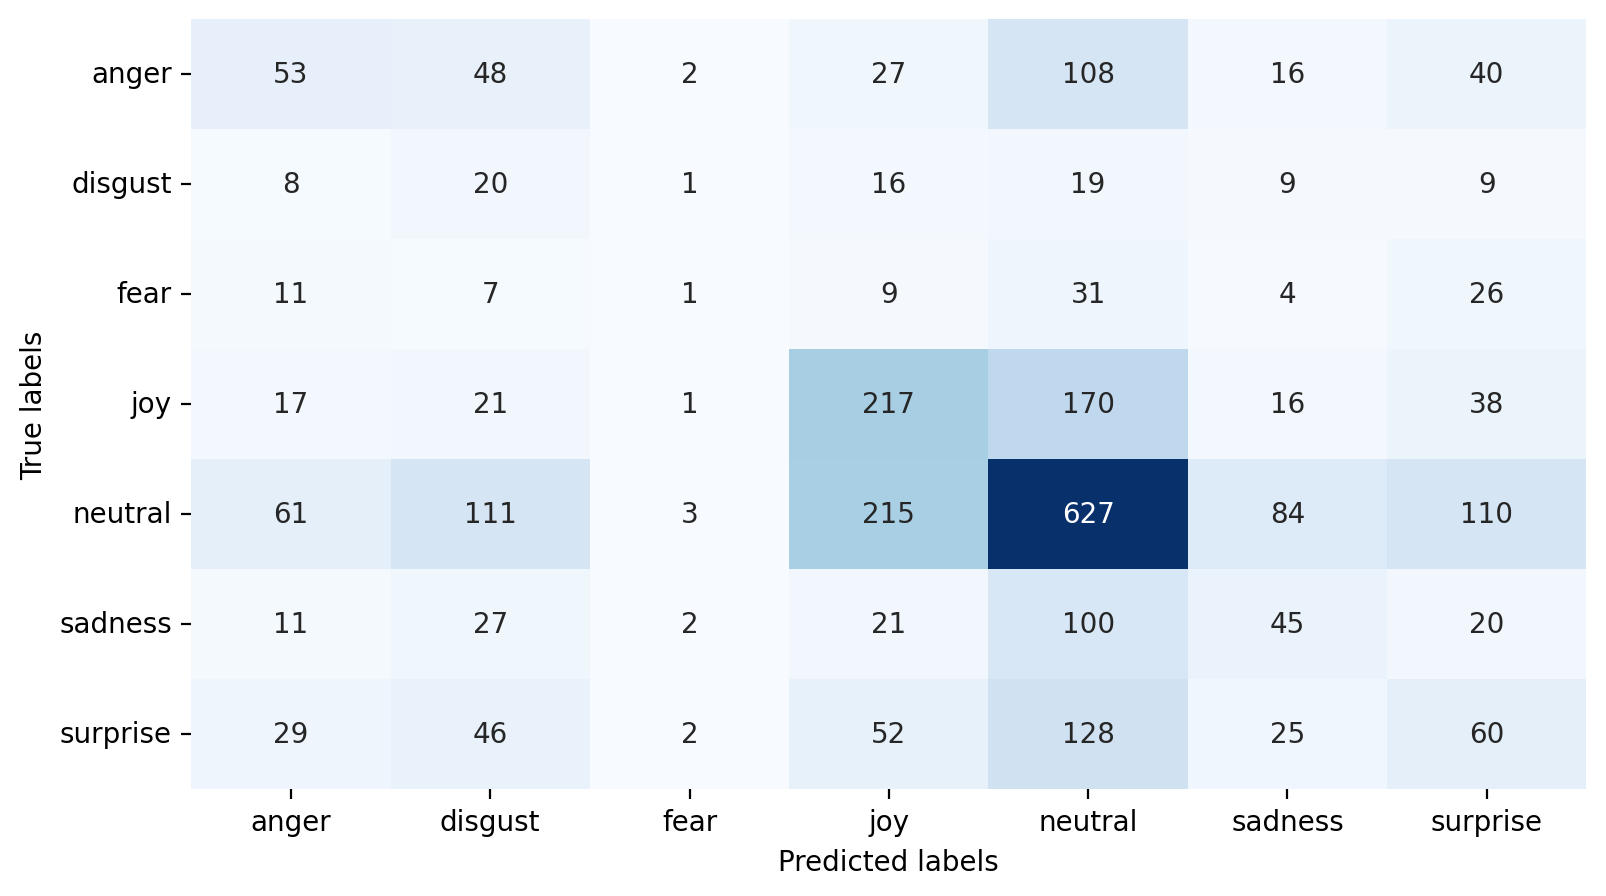

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.rc('figure', figsize=(9, 5))

labels_ordered = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

cm = confusion_matrix(test_labels, predicted_labels_list, labels=labels_ordered)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_ordered, yticklabels=labels_ordered, cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig(f'./experiments/plots/EkmanClassifier/confusion_matrix.png')
plt.show()

In [18]:
# count accuracy, f1 micro and f1 macro
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(test_labels, predicted_labels_list)
f1_micro = f1_score(test_labels, predicted_labels_list, average='micro')
f1_macro = f1_score(test_labels, predicted_labels_list, average='macro')

print(f'Accuracy: {accuracy}')
print(f'F1 micro: {f1_micro}')
print(f'F1 macro: {f1_macro}')

Accuracy: 0.3755506607929515
F1 micro: 0.3755506607929515
F1 macro: 0.24134902435886652


What if during evaluation we don't consider those utterances which were attributed none of the allowed classes?

In [39]:
predicted_labels_dict = {}
for k, v in predicted_labels.items():
    predicted_labels_dict[k] = v['predicted_emotion']

n_before_cleaning = len(predicted_labels_dict)

print("Before cleaning: ", n_before_cleaning)

wrong_fnames = []
for k, v in predicted_labels_dict.items():
    if v not in ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']:
        wrong_fnames.append(k)

# get indices of the wrong predictions from the test_video_fnames file
wrong_indices = np.sort([test_video_fnames.index(fname) for fname in wrong_fnames]).tolist()
print(wrong_indices[:10], "...", wrong_indices[-10:])

cleaned_test_labels = [test_labels[i] for i in range(len(test_labels)) if i not in wrong_indices]
cleaned_predicted_labels_list = [predicted_labels_dict[k] for k in test_video_fnames if k not in wrong_fnames]

print(len(cleaned_test_labels), len(cleaned_predicted_labels_list))
print("Removed items: ", n_before_cleaning - len(cleaned_test_labels), len(wrong_indices), f"{len(wrong_indices)/n_before_cleaning:.3f}%")
# # get value counts of all labels
# predicted_labels_df = pd.Series(predicted_labels_dict)
# predicted_labels_df.value_counts()

Before cleaning:  2724
[18, 34, 39, 53, 77, 83, 84, 92, 105, 111] ... [2650, 2663, 2687, 2691, 2694, 2705, 2710, 2714, 2717, 2718]
2350 2350
Removed items:  374 374 0.137%


In [40]:
# value counts of wrong predictions
wrong_predictions_true_labels = [test_labels[i] for i in wrong_indices]

display(pd.Series(wrong_predictions_true_labels).value_counts())

# print percents
pd.Series(wrong_predictions_true_labels).value_counts(normalize=True)

neutral     192
joy          65
surprise     46
anger        39
sadness      19
fear         11
disgust       2
Name: count, dtype: int64

neutral     0.513369
joy         0.173797
surprise    0.122995
anger       0.104278
sadness     0.050802
fear        0.029412
disgust     0.005348
Name: proportion, dtype: float64

The model's mistakes were not conditioned by any specific emotion, as the distribution is similar to the test dataset iteself

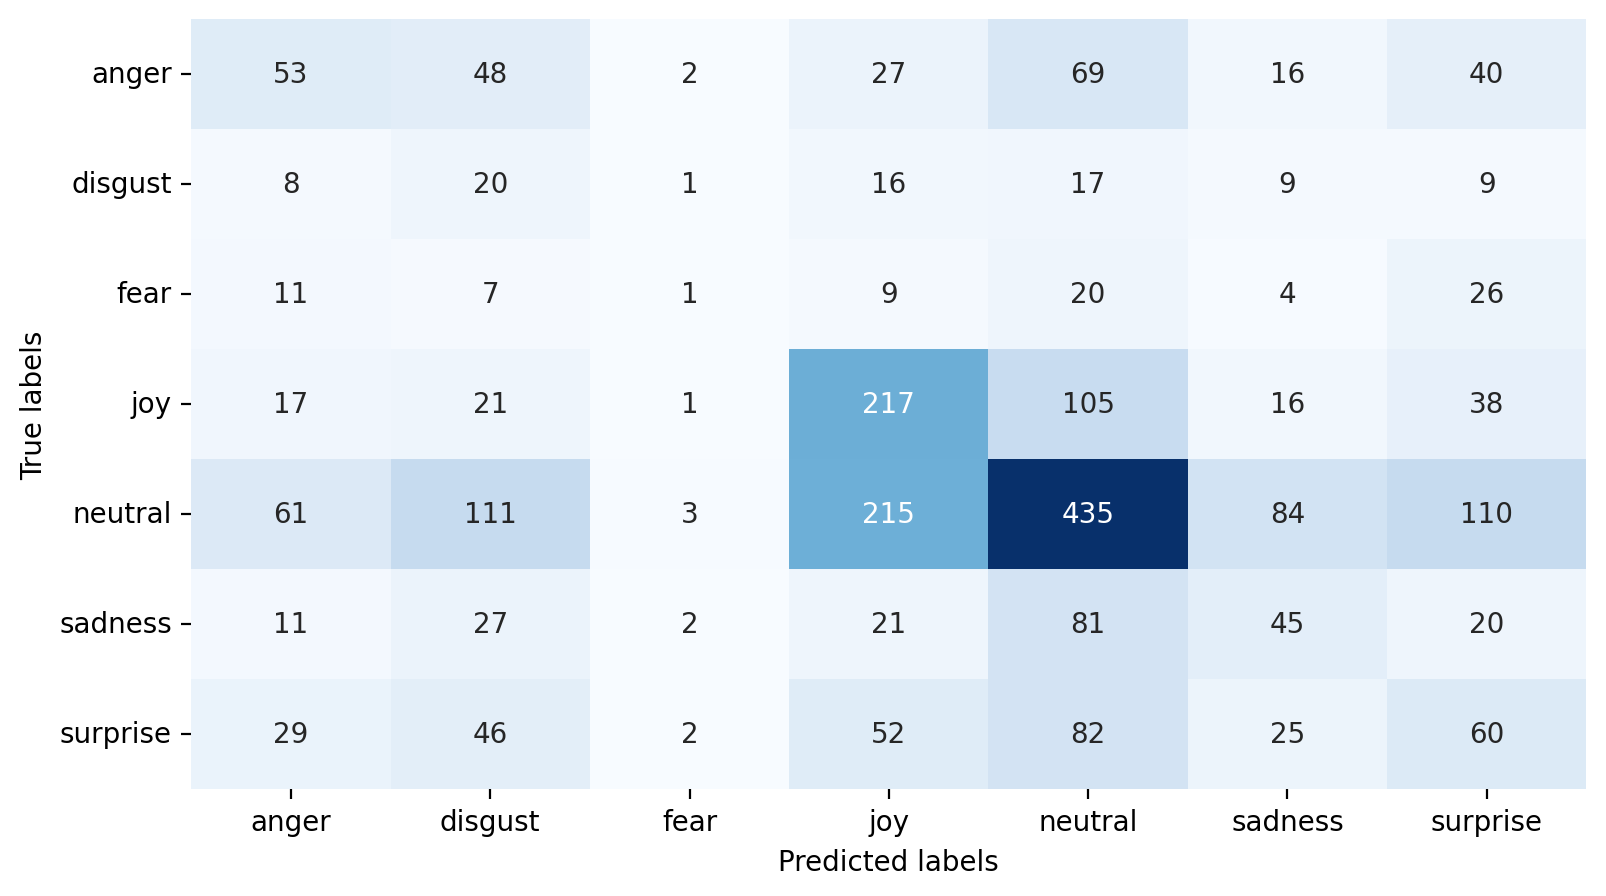

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.rc('figure', figsize=(9, 5))

labels_ordered = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

cm = confusion_matrix(cleaned_test_labels, cleaned_predicted_labels_list, labels=labels_ordered)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_ordered, yticklabels=labels_ordered, cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig(f'./experiments/plots/gpt-4o/confusion_matrix.png')
plt.show()

In [45]:
# count accuracy, f1 micro and f1 macro
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(cleaned_test_labels, cleaned_predicted_labels_list)
f1_micro = f1_score(cleaned_test_labels, cleaned_predicted_labels_list, average='micro')
f1_macro = f1_score(cleaned_test_labels, cleaned_predicted_labels_list, average='macro')

print(f'Accuracy: {accuracy}')
print(f'F1 micro: {f1_micro}')
print(f'F1 macro: {f1_macro}')

Accuracy: 0.3536170212765957
F1 micro: 0.3536170212765957
F1 macro: 0.24513948327418952


In [44]:
pd.Series(test_labels).value_counts()

# percents
pd.Series(test_labels).value_counts(normalize=True)

neutral     0.444567
joy         0.176211
surprise    0.125551
anger       0.107930
sadness     0.082966
fear        0.032673
disgust     0.030103
Name: proportion, dtype: float64